# Task 3 : Super-Resolution using Random Fourier Features (RFF) [4 Marks]

Demonstrate the following applications using the cropped image from the notebook:

1. Super-resolution: Perform superresolution on the image shown in notebook to enhance its resolution by factor 2. Show a qualitative comparison of original and reconstructed image. (i.e display original image and the image you created side by side) [3 Marks]

2. The above only helps us with a qualitative comparison. Let us now do a quantitative comparison. Compute the below given metrics: [1 Marks]
 - RMSE on predicted v/s ground truth high resolution image
 - Peak SNR on predicted v/s ground truth high resolution image

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import cv2

import numpy as np

import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange


In [ ]:
def load_image(path): # given path to an image this function shows the image and returns the image tensor
  if (os.path.exists(path)):
    # read the image using torchvision and convert it to tensor because the model expects a tensor
    img = torchvision.io.read_image(path)
    print("Tensor shape: ", img.shape)
    plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
    return img
  else:
    print("File not found")
    return None


def normalize_image(image): # given an image tensor this function normalizes the image and returns the normalized image tensor between 0 and 1
  original_image = image.shape
  scaler = preprocessing.MinMaxScaler()
  image = image.reshape(-1, 1) # flatten
  scaler.fit(image)
  scaled_image = scaler.transform(image).reshape(original_image) # reshape back to original shape
  scaled_image = torch.tensor(scaled_image).float().to(device)
  return scaled_image


def crop_image(image, crop_size, start_x, start_y):  # given an image tensor, crop size, start x and start y this function crops the image and returns the cropped image tensor
  cropped_image = torchvision.transforms.functional.crop(
      image.cpu(), start_x, start_y, crop_size, crop_size)
  print("Cropped image shape: ", cropped_image.shape)
  plt.imshow(rearrange(cropped_image, 'c h w -> h w c').cpu().numpy())
  return cropped_image

Tensor shape:  torch.Size([3, 1365, 2048])
Cropped image shape:  torch.Size([3, 400, 400])


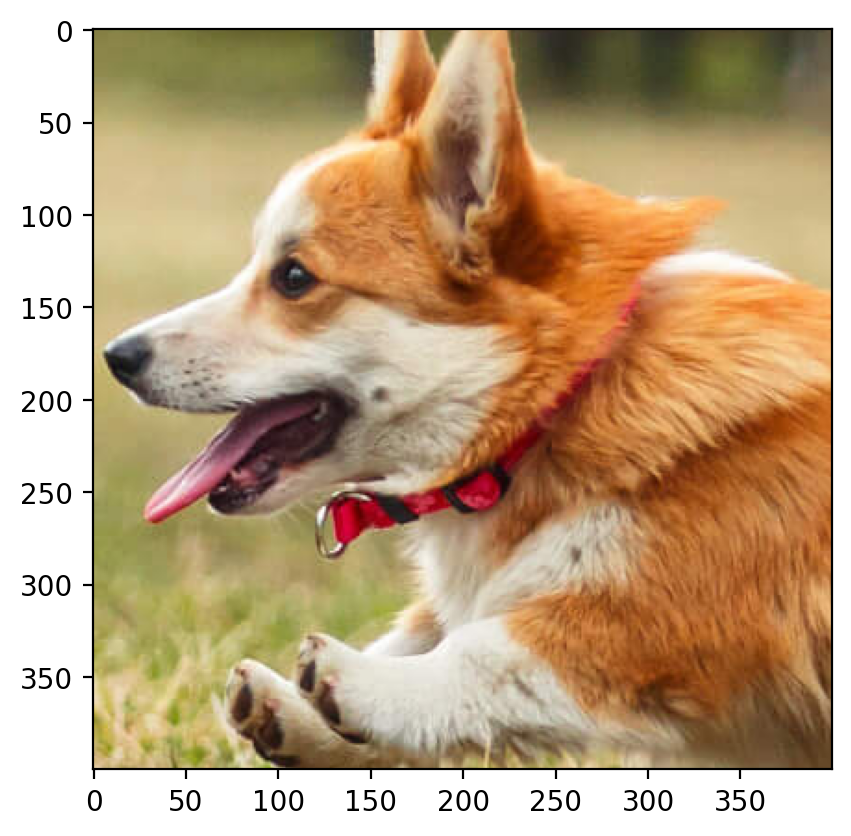

In [ ]:
image_path = "images/dog.jpg"
image = load_image(image_path)

normalized_image = normalize_image(image) # 0.0 to 1.0
cropped_image = crop_image(normalized_image, 400, 550, 800)

torch.Size([3, 200, 200])


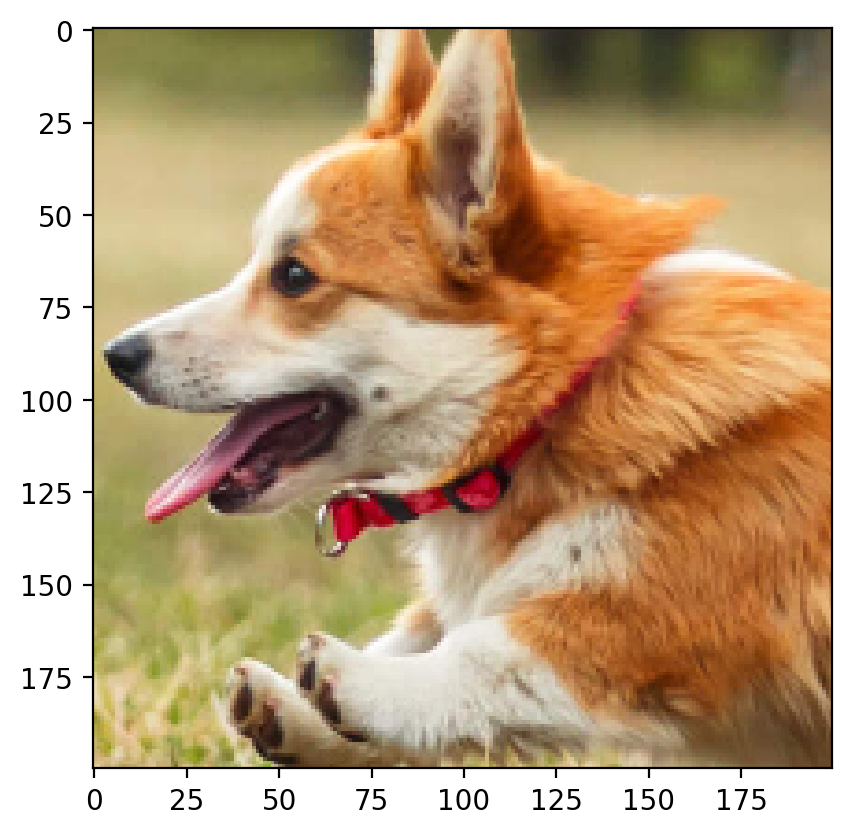

In [ ]:
# downsample the image by a factor of 2 using average pooling method
scale = 2

num_channels, height, width = cropped_image.shape
height //= scale # reduce the height by a factor of 2
width //= scale # reduce the width by a factor of 2

low_res_image = torch.zeros((num_channels,height,width)).to(device) # create a tensor to store the low resolution image

for i in range(height):
  for j in range(width):
    low_res_image[:, i, j] = torch.mean(cropped_image[:, 2 * i:2 * i + 2, 2 * j:2 * j + 2], dim=(1, 2)) # average the pixel values in the 2x2 neighborhood, dim = (1, 2) means average over the height and width

print(low_res_image.shape)
plt.imshow(rearrange(low_res_image, 'c h w -> h w c').cpu().numpy())

In [ ]:
def extract_coordinates_pixels(image): # this function extracts the coordinates and pixel values of an image tensor and returns them
  channels, height, width = image.shape
  coords = [] # store the coordinates

  for y in range(height):
    for x in range(width):
      coords.append([x, y])

  coords = torch.tensor(coords, dtype=torch.float32)
  pixel_values = rearrange(image, 'c h w -> (h w) c').float() # rearrange the image tensor to have the pixel values in the first dimension by flatten the height and width dimensions

  print("Coordinates shape: ", coords.shape)
  print("Pixel values shape: ", pixel_values.shape)
  return coords.to(device), pixel_values.to(device)

In [ ]:
coords, pixels = extract_coordinates_pixels(low_res_image)

Coordinates shape:  torch.Size([40000, 2])
Pixel values shape:  torch.Size([40000, 3])


In [ ]:
coords.max(), coords.min()

(tensor(199.), tensor(0.))

In [ ]:
def normalize_tensor(tensor): # given a tensor this function normalizes the tensor between -1 and 1 and returns the normalized tensor
  scalar = preprocessing.MinMaxScaler(feature_range=(-1, 1))
  scalar.fit(tensor.cpu())
  scaled_tensor = scalar.transform(tensor.cpu())
  scaled_tensor = torch.tensor(scaled_tensor).float().to(device)
  return scaled_tensor

In [ ]:
coords = normalize_tensor(coords)

In [ ]:
print(coords.min(), coords.max())

tensor(-1.) tensor(1.)


In [ ]:
def create_linear_model(input_dim, output_dim):
  # nn is the neural network module
  return nn.Linear(input_dim, output_dim).to(device)

# create RFF features
def create_rff_features(tensor, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=42)
    tensor = torch.tensor(rff.fit_transform(tensor.cpu().numpy())).float().to(device)
    return tensor

def train(coords, pixels, model, learning_rate=0.01, epochs=1000, threshold=1e-6, verbose=True):
    """
    Train the model with early stopping based on loss change.

    coords: torch.Tensor of shape (num_samples, 2) - the coordinate map.
    pixels: torch.Tensor of shape (num_samples, num_channels) - the pixel values.
    model: torch.nn.Module - the model to train.
    learning_rate: float - the learning rate for the optimizer.
    epochs: int - the maximum number of epochs for training.
    verbose: bool - whether to print progress me    ssages.
    threshold: float - the threshold for early stopping based on the change in loss.

    Returns: the final loss value (float).
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    previous_loss = float('inf')

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(coords)
        loss = criterion(outputs, pixels)
        loss.backward()
        optimizer.step()

        # check for early stopping
        if abs(previous_loss - loss.item()) < threshold:
            print(f"Stopping early at epoch {epoch} with loss: {loss.item():.6f}")
            break

        previous_loss = loss.item()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()

def plot_reconstructed_and_original_image(original_image, model, coords, flag, title=""):
    # if the flag is 1 then the image is the original one, if the flag is 2 then the image is the downsampled one
    num_channels, height, width = original_image.shape
    model.eval()  # set the model to evaluation mode which disables dropout and batch normalization
    with torch.no_grad():  # disable gradient calculation as we don't need it for visualizing to speed it the process
        outputs = model(coords)
        # apply sigmoid activation
        # outputs = torch.sigmoid(outputs)
        # outputs = (outputs - outputs.min()) / (outputs.max() - outputs.min())
        # improve the contrast
        # outputs = torch.pow(outputs, 1.2)
        if (flag == 1):
            outputs = outputs.reshape(height, width, num_channels)
        else:
            outputs = outputs.reshape(height * 2, width * 2, num_channels)

    fig = plt.figure(figsize=(6, 4))
    # this allows us to create a flexible grid layout for plotting multiple subplots
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    ax1.imshow(original_image.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    for a in [ax0, ax1]:
        a.axis("off")
    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [ ]:
# parameters are coordinates, number of features, and sigma
image_rff = create_rff_features(coords, 10000, 0.01)

In [ ]:
model = create_linear_model(image_rff.shape[1], 3)
model.to(device)

train(image_rff, pixels, model, learning_rate=0.01,
      epochs=1000, threshold=1e-9, verbose=True)

Epoch 0 loss: 0.347933
Epoch 100 loss: 0.013757
Epoch 200 loss: 0.006402
Epoch 300 loss: 0.003633
Epoch 400 loss: 0.002336
Epoch 500 loss: 0.001669
Epoch 600 loss: 0.001304
Epoch 700 loss: 0.001096
Epoch 800 loss: 0.000972
Epoch 900 loss: 0.000894


0.0008442500256933272

In [ ]:
def create_coordinate_map(height, width): # given the height and width of an image this function creates a coordinate map and returns it
  coords = []
  for y in range(height):
    for x in range(width):
      coords.append([x, y])

  return torch.tensor(coords, dtype=torch.float32).to(device)

In [ ]:
coords_new = create_coordinate_map(400, 400) # create the coordinate map for the new image
coords_new = normalize_tensor(coords_new)

In [ ]:
image_rff_new = create_rff_features(coords_new, 10000, 0.01) # create the RFF features for the new image

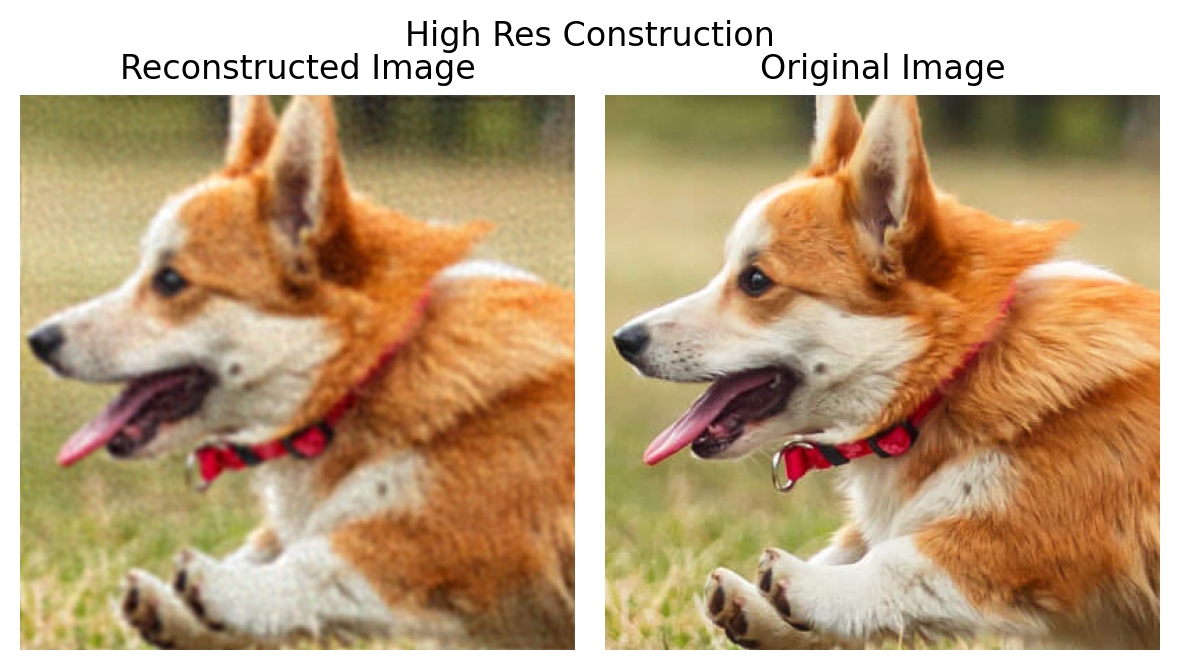

In [ ]:
plot_reconstructed_and_original_image(cropped_image, model, image_rff_new, title="High Res Construction", flag = 1)

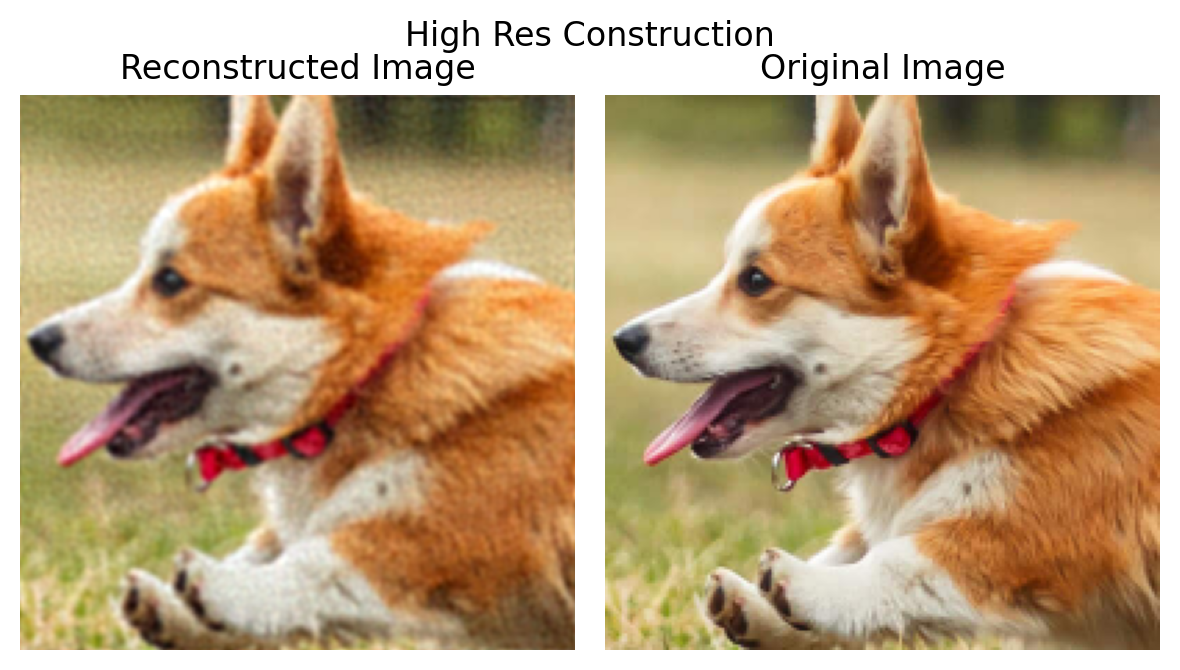

In [ ]:
plot_reconstructed_and_original_image(low_res_image, model, image_rff_new, title="High Res Construction", flag = 0)

In [ ]:
def get_reconstructed_image(model, coords, image_rff, height, width): # given a model, coordinates, RFF features, height, and width this function returns the reconstructed image
  model.eval()
  with torch.no_grad():
    outputs = model(image_rff)
    outputs = outputs.reshape(height, width, 3)
  return outputs

In [ ]:
reconstructed_image = get_reconstructed_image(model, coords_new, image_rff_new, 400, 400)
reconstructed_image = rearrange(reconstructed_image, 'c h w -> w h c').cpu() # rearrange the image tensor to make it compatible with the below code

In [ ]:
!pip install torchmetrics

from torchmetrics.functional.image import peak_signal_noise_ratio
from torchmetrics.functional.regression import mean_squared_error

# Calculate and report the RMSE and PSNR metrics.
def metrics(img, reconstructed_img):
    rmse = mean_squared_error(target = img,
                             preds=reconstructed_img,
                             squared=False)
    psnr = peak_signal_noise_ratio(target=img,
                                   preds=reconstructed_img)
    return rmse, psnr

In [ ]:
reconstructed_image.shape, cropped_image.shape

(torch.Size([3, 400, 400]), torch.Size([3, 400, 400]))

In [ ]:
print(cropped_image.shape)
print(reconstructed_image.shape)

torch.Size([3, 400, 400])
torch.Size([3, 400, 400])


In [ ]:
rmse, psnr = metrics(cropped_image.transpose(1, 2).reshape(-1, 1), reconstructed_image.reshape(-1, 1))
print("RMSE: ", rmse)
print("PSNR: ", psnr)

RMSE:  tensor(0.0345)
PSNR:  tensor(29.2341)
